In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
seed = 10

In [2]:
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")
len_train = len(train)
IDtest = test["PassengerId"]

In [3]:
def preprocess(train,test,check_out,bound=2):    
    print("Features considered for outlier detection: ",check_out)
    #Tukey method:
    candidates = []
    for col in check_out:
        Q1 = np.percentile(train[col], 25)
        Q3 = np.percentile(train[col],75)
        iqr = (Q3-Q1)*1.5
        outliers = train[(train[col] > Q3+iqr) | (train[col] < Q1-iqr)].index
        candidates.extend(outliers)
    to_remove = list()
    for key,value in Counter(candidates).items():
        if value>2:
            to_remove.append(key)
    eliminated = len(to_remove)
    print(to_remove)
    train = train.drop(to_remove,axis=0).reset_index(drop=True)
    print("Null Summary:")
    #print(all_data.isnull().sum())
    #all_data.fillna(np.nan,inplace = True)
    return train,eliminated

In [4]:
check_out = []
for feature in train.columns.values[2:]:
    if np.issubdtype(train[feature].dtype, np.number):
        check_out.append(feature)
train,elim = preprocess(train,test,check_out)
len_train = len(train)
data = pd.concat(objs= [train,test],axis = 0).reset_index(drop=True)
data.fillna(np.nan,inplace = True)

Features considered for outlier detection:  ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]
Null Summary:


In [5]:
data["Fare"].fillna(data["Fare"].median(),inplace=True)
data["Embarked"].fillna("S",inplace=True)

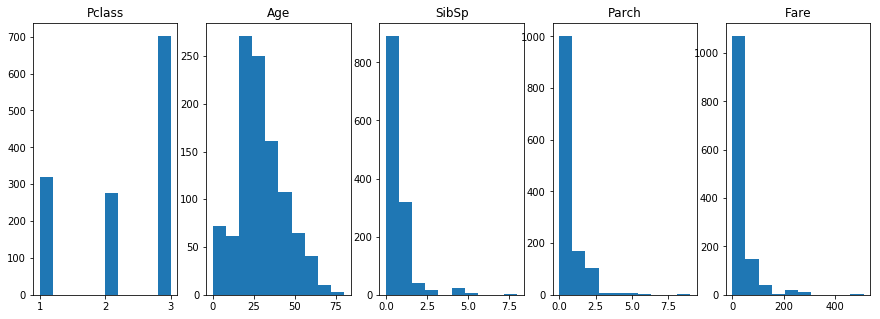

In [6]:
fig, axs = plt.subplots(nrows=1,ncols=5, figsize=(15,5))
for ax, col in zip(fig.axes,check_out):
    ax.hist(data[col].dropna())
    ax.set_title(col)

In [7]:
#preprocessing
#credit : https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook
#thanks for great work!

data["Fare"] = data["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
data["Sex"] = data["Sex"].map({"male": 0, "female":1})

nan_index = list(data["Age"][data["Age"].isnull()].index)
for i in nan_index :
    age_med = data["Age"].median()
    age_pred = data["Age"][((data['SibSp'] == data.iloc[i]["SibSp"]) & (data['Parch'] == data.iloc[i]["Parch"]) & (data['Pclass'] == data.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        data['Age'].iloc[i] = age_pred
    else :
        data['Age'].iloc[i] = age_med

dataset_title = [i.split(",")[1].split(".")[0].strip() for i in data["Name"]]
data["Title"] = pd.Series(dataset_title)
data["Title"] = data["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data["Title"] = data["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
data["Title"] = data["Title"].astype(int)
data.drop(labels = ["Name"], axis = 1, inplace = True)
data["Fsize"] = data["SibSp"] + data["Parch"] + 1
data['Single'] = data['Fsize'].map(lambda s: 1 if s == 1 else 0)
data['SmallF'] = data['Fsize'].map(lambda s: 1 if  s == 2  else 0)
data['MedF'] = data['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
data['LargeF'] = data['Fsize'].map(lambda s: 1 if s >= 5 else 0)
data = pd.get_dummies(data, columns = ["Title"])
data = pd.get_dummies(data, columns = ["Embarked"], prefix="Em")
data["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in data['Cabin'] ])
data = pd.get_dummies(data, columns = ["Cabin"],prefix="Cabin")
Ticket = []
for i in list(data.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
data["Ticket"] = Ticket
data = pd.get_dummies(data, columns = ["Ticket"], prefix="T")
data.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [8]:
data.head(2)

,Age,Fare,Parch,Pclass,Sex,SibSp,Survived,Fsize,Single,SmallF,...,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X
0,22.0,1.981001,0,3,0,1,0.0,2,0,1,...,0,0,0,0,0,0,0,0,0,0
1,38.0,4.266662,0,1,1,1,1.0,2,0,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
train = data.iloc[:len_train]
test = data.iloc[len_train:]
Y_train = train["Survived"]
train.drop(["Survived"],axis=1,inplace=True)
test.drop(["Survived"],axis=1,inplace=True)

In [10]:
models = []
models.append(RandomForestClassifier(random_state=seed))
models.append(RandomForestClassifier(n_estimators=5,criterion="entropy",random_state=seed))
models.append(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=seed),learning_rate=0.03,n_estimators=100,random_state=seed))
models.append(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=seed),learning_rate=0.1,random_state=seed))
models.append(LogisticRegression(random_state=seed))
models.append(KNeighborsClassifier())
models.append(KNeighborsClassifier(n_neighbors=3))
models.append(KNeighborsClassifier(n_neighbors=10))
models.append(MLPClassifier(random_state=seed))
models.append(MLPClassifier(activation="logistic",random_state=seed))
models.append(MLPClassifier(hidden_layer_sizes=(50,50),activation="logistic",random_state=seed))

In [11]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [12]:
kfold = StratifiedKFold(n_splits=10)
accuracies = []
stds=[]
cv_results = []
for i,model in enumerate(models) :
    cv_results.append(cross_val_score(model, train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
    accuracies.append(cv_results[i].mean())
    stds.append(cv_results[i].std())
    print(accuracies[i])

0.8150280898876405
0.7889044943820225
0.8025663942798774
0.802579162410623
0.820658835546476
0.7991189989785495
0.7900280898876404
0.7661772216547498
0.8240806945863126
0.8252042900919305
0.8229315628192033


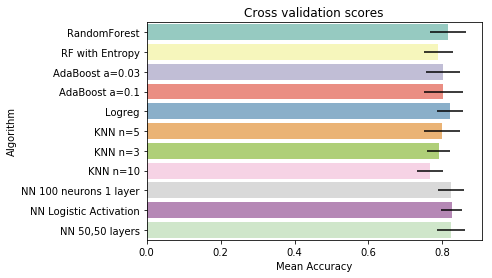

In [13]:
algorithms = ["RandomForest","RF with Entropy","AdaBoost a=0.03",
"AdaBoost a=0.1","Logreg","KNN n=5","KNN n=3","KNN n=10","NN 100 neurons 1 layer","NN Logistic Activation","NN 50,50 layers"]
cv_res = pd.DataFrame({"Accuracies":accuracies,"CrossValerrors": stds,"Algorithm":algorithms})

g = sns.barplot("Accuracies","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':stds})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [14]:
best_estimators = []

In [15]:
MLP = MLPClassifier(random_state=seed)
svc_param_grid = {'activation': ['logistic',"relu","tanh"],
                  "learning_rate_init":[0.001,0.003,0.01],
                  "learning_rate":["constant","adaptive"],
                  }
MLPfind = GridSearchCV(MLP,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

In [16]:
MLPfind.fit(train,Y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   18.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=10, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'activation': ['logistic', 'relu', 'tanh'], 'learning_rate_init': [0.001, 0.003, 0.01], 'learning_rate': ['constant', 'adaptive']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [17]:
bestNN = MLPfind.best_estimator_
best_estimators.append((bestNN,"Neural Net"))

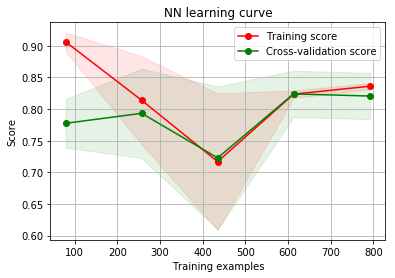

In [18]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5),to_plot=None):
    """Generate a simple plot of the test and training learning curve"""
    if to_plot is None:
        fig,axes = plt.subplots(1,1)
        ax = fig.axes[0]
    else:
        ax = to_plot
    if ylim is not None:
        plt.ylim(*ylim)
    ax.set_title(title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    ax.legend(loc="best")
    return ax

g = plot_learning_curve(bestNN,"NN learning curve",train,Y_train,cv=kfold)

In [57]:
def plot_best_curves(estimators:list):
    fig, axs = plt.subplots(nrows=len(estimators)//2,ncols=2, figsize=(20,16))
    for ax,i in zip(fig.axes,range(len(estimators))):
        plot_learning_curve(estimators[i][0],estimators[i][1],train,Y_train,to_plot=ax)

In [20]:
Ada = AdaBoostClassifier(random_state=seed)
svc_param_grid = {'base_estimator': [DecisionTreeClassifier(criterion="entropy",random_state = seed),
                                    DecisionTreeClassifier(criterion="gini",random_state = seed)],
                  "n_estimators":[30,50,100],
                  "learning_rate":[0.1,0.3,1],
                  }
AdaFind = GridSearchCV(Ada,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

In [21]:
AdaFind.fit(train,Y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   13.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=10),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'base_estimator': [DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh...te=10,
            splitter='best')], 'n_estimators': [30, 50, 100], 'learning_rate': [0.1, 0.3, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [22]:
best_estimators.append((AdaFind.best_estimator_,"AdaBoost"))

In [23]:
RF = RandomForestClassifier(random_state=seed)
cols = len(train.columns)
svc_param_grid = {"n_estimators":[cols//2,cols//4,cols//8,cols//16],
                  "criterion":["gini","entropy"]
                  }
RFFind = GridSearchCV(RF,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

In [24]:
RFFind.fit(train,Y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.9s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_estimators': [32, 16, 8, 4], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [25]:
best_estimators.append((RFFind.best_estimator_,"RF"))

In [74]:
SVMC = SVC(random_state=seed,probability=True)
svc_param_grid = {"C":[1,3,10,30],
                  "kernel":["rbf","sigmoid"]
                  }
SVMFind = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

In [75]:
SVMFind.fit(train,Y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    6.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=10, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'C': [1, 3, 10, 30], 'kernel': ['rbf', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [77]:
best_estimators.append((SVMFind.best_estimator_,"SVM"))

In [41]:
GBoost = GradientBoostingClassifier(random_state=seed)
svc_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [20,50,100],
              'max_features': [0.5,0.3, 0.1] 
              }
GBoostFind = GridSearchCV(GBoost,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
GBoostFind.fit(train,Y_train)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 342 tasks      | elapsed:   24.0s
[Parallel(n_jobs=4)]: Done 655 tasks      | elapsed:   46.8s
[Parallel(n_jobs=4)]: Done 1100 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 1550 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 1613 out of 1620 | elapsed:  2.0min remaining:    0.5s
[Parallel(n_jobs=4)]: Done 1620 out of 1620 | elapsed:  2.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'loss': ['deviance'], 'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.05, 0.01], 'max_depth': [4, 8], 'min_samples_leaf': [20, 50, 100], 'max_features': [0.5, 0.3, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [42]:
best_estimators.append((GBoostFind.best_estimator_,"Gradient Boosting"))

In [52]:
ExtraTrees = ExtraTreesClassifier(random_state=seed)
ex_param_grid = {"max_features": [3, 5, 10],
              "min_samples_split": [2, 3, 10,20],
              "min_samples_leaf": [1, 3, 10,20],
              "bootstrap": [True,False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}
ETFind = GridSearchCV(ExtraTrees,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
ETFind.fit(train,Y_train)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   47.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 1920 out of 1920 | elapsed:  4.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_features': [3, 5, 10], 'min_samples_split': [2, 3, 10, 20], 'min_samples_leaf': [1, 3, 10, 20], 'bootstrap': [True, False], 'n_estimators': [100, 300], 'criterion': ['gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [ ]:
best_estimators.append((ETFind.best_estimator_,"Extra Trees"))

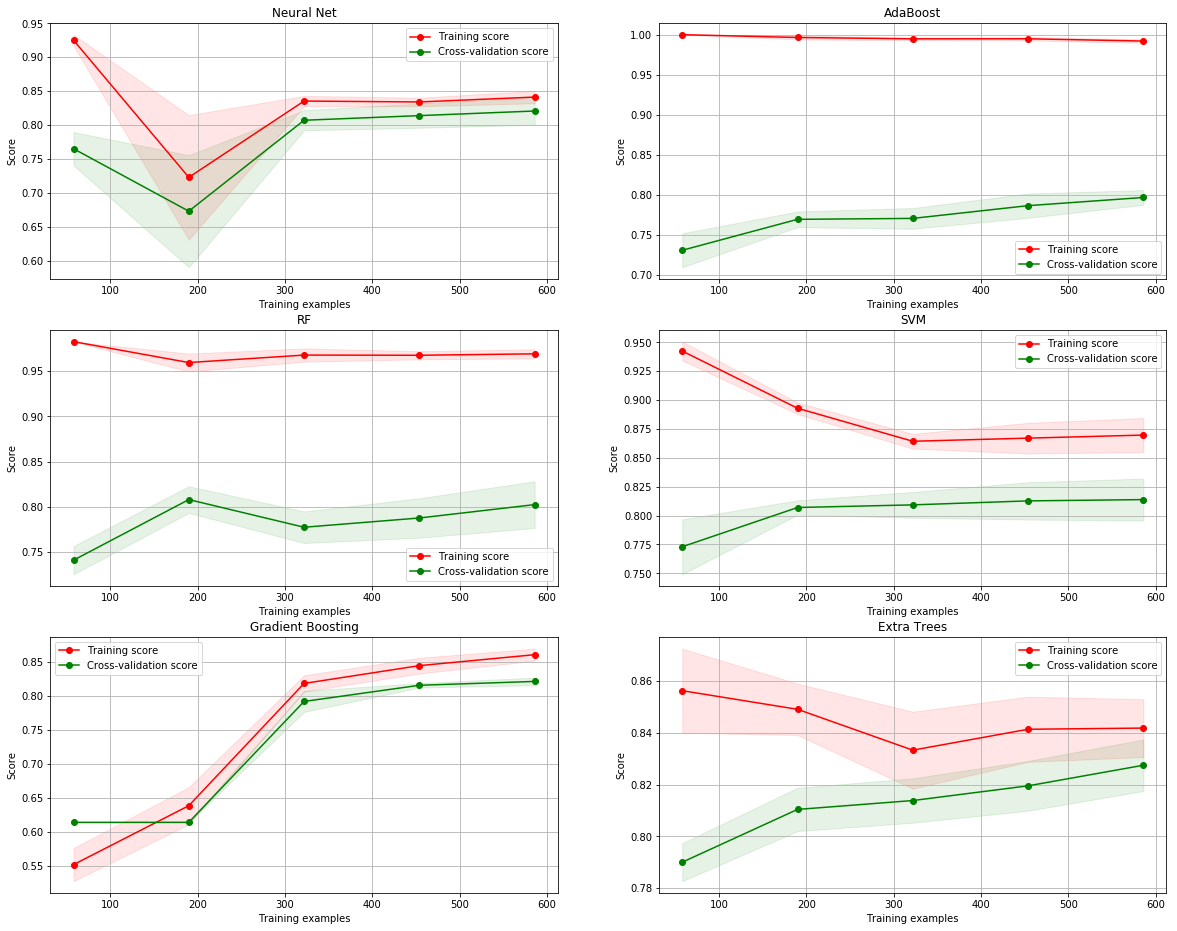

In [78]:
plot_best_curves(best_estimators)

In [79]:
all_estimators = [(e[1],e[0]) for e in best_estimators]
votingC = VotingClassifier(estimators=all_estimators, voting='soft', n_jobs=4)
votingC = votingC.fit(train, Y_train)

In [88]:
pd.concat([pd.read_csv("datasets/test.csv")["PassengerId"],pd.Series(votingC.predict(test).astype(int),name="Survived")],axis=1).to_csv("datasets/submission.csv",index=False)